<a href="https://colab.research.google.com/github/bchuchucaa/RNNConsumoDeAgua/blob/main/LstmWaterConsumption1990_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTACION DE LIBRERIAS

In [222]:
import pandas as pd
import numpy as np
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense,RepeatVector,TimeDistributed, GRU, Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow import keras
#Librerias para graficos
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import pyplot
#Manejo de fechas
from datetime import datetime
from pandas.tseries.offsets import MonthBegin,MonthEnd

print('LIBRERIAS CORRECTAMENTE IMPORTADAS')

LIBRERIAS CORRECTAMENTE IMPORTADAS


##Lectura de datos

In [188]:
df_cpu_pivot = pd.read_csv('/content/1990-2021.csv')
df_cpu_pivot = df_cpu_pivot.rename(columns={'United States(USD)':'Jimmy Magguill','Europe(EUR)':'Michael Hermantrout','Japan(JPY)':'Kim Yanza','United Kingdom(GBP)':'Israel Canzas'})
df_cpu_pivot['Date'] = pd.to_datetime(df_cpu_pivot['Date'])
df_cpu_pivot.head(2)

,Date,Jimmy Magguill,Michael Hermantrout,Kim Yanza,Israel Canzas,Canada(CAD),Switzerland(CHF),India(INR),China(CNY),Turkey(TRY),Saudi Arabia(SAR),Indonesia(IDR),United Arab Emirates(AED),Thailand(THB),Vietnam(VND),Egypt(EGP),South Korean(KRW),Australia(AUD),South Africa(ZAR)
0,1990-01-31,415.1,321.3,59972.3,247.1,492.0,623.8,7041.0,1930.2,1.0,1557.4,745400.5,1524.9,10623.3,1867170.0,1059.9,283240.8,540.0,1063.2
1,1990-02-28,407.7,316.2,60672.5,241.2,485.7,607.9,6957.4,1936.8,1.0,1527.7,747408.3,1496.0,10494.1,1853648.1,1085.6,282356.4,534.1,1040.4


# Data Exploration

In [200]:
print('Fecha de inicio :',df_cpu_pivot.Date.min(),'\n',' Fecha de fin : ',df_cpu_pivot.Date.max())

Fecha de inicio : 1990-01-31 00:00:00 
  Fecha de fin :  2021-07-30 00:00:00


In [201]:
trace1 = go.Scatter(
 x = df_cpu_pivot['Date'],
 y = df_cpu_pivot[df_cpu_pivot.columns[1]],
 mode = 'lines',
 name = df_cpu_pivot.columns[1]
)
trace2 = go.Scatter(
 x = df_cpu_pivot['Date'],
 y = df_cpu_pivot[df_cpu_pivot.columns[2]],
 mode = 'lines',
 name = df_cpu_pivot.columns[2]
)
trace3 = go.Scatter(
 x = df_cpu_pivot['Date'],
 y = df_cpu_pivot[df_cpu_pivot.columns[4]],
 mode = 'lines',
 name = df_cpu_pivot.columns[4]
)
layout = go.Layout(
 title = 'CONSUMO DE AGUA',
 xaxis = {'title' : 'Date'},
 yaxis = {'title' : 'Consumo'}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

##Separacion del dataset en conjunto de entranamiento y pruebas


In [204]:
train_test_split = datetime.strptime('01.12.2018', '%d.%m.%Y')
df_train = df_cpu_pivot.loc[df_cpu_pivot['Date'] < train_test_split]
df_test = df_cpu_pivot.loc[df_cpu_pivot['Date'] >= train_test_split]
cpu_list = [i for i in df_cpu_pivot.columns if i != 'Date']
scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(df_train[cpu_list])
scaled_test = scaler.transform(df_test[cpu_list])

In [205]:
def split_sequence(sequence, look_back, forecast_horizon):
 X, y = list(), list()
 for i in range(len(sequence)):     
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)   
 return np.array(X), np.array(y)

In [321]:
#Tomamos 3 meses y como salida el siguiente mes
LOOK_BACK = 3
FORECAST_RANGE = 3
n_features = len(cpu_list)
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(342, 3, 18)
(342, 3, 18)
(27, 3, 18)
(27, 3, 18)


In [207]:
checkpoint_filepath = 'path_to_checkpoint_filepath'
checkpoint_callback = ModelCheckpoint(   
 filepath=checkpoint_filepath,
 save_weights_only=False,
 monitor='val_loss',
 mode='min',
 save_best_only=True)
#Funcion para controlar la evolucion del error
early_stopping_callback = EarlyStopping(
 monitor='val_loss',
 min_delta=0.001,
 patience = 10,
 mode='min'
)
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.001, mode='min', patience=3, min_lr=0.0001)

In [208]:
#Funcion para obtener la transformacion inversa de los datos estandarizados
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse 

In [209]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)

In [210]:
def graph_predictions(y_test_inverse,yhat_inverse):
  label=list(range(0,len(y_test_inverse)))
  plt.plot(label, y_test_inverse, label = "Real")
  plt.plot(label, yhat_inverse, label = "Prediccion")
  plt.legend()
  plt.show()

# Entrenamiento del modelo y evaluacion del error



Epoch 1/120
17/17 [==============================] - 4s 43ms/step - loss: 0.1814 - val_loss: 0.5436 - lr: 0.0010
Epoch 2/120
17/17 [==============================] - 0s 12ms/step - loss: 0.1445 - val_loss: 0.4048 - lr: 0.0010
Epoch 3/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0929 - val_loss: 0.2187 - lr: 0.0010
Epoch 4/120
17/17 [==============================] - 0s 10ms/step - loss: 0.0493 - val_loss: 0.1232 - lr: 0.0010
Epoch 5/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0236 - val_loss: 0.0545 - lr: 0.0010
Epoch 6/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0118 - val_loss: 0.0261 - lr: 0.0010
Epoch 7/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0080 - val_loss: 0.0207 - lr: 0.0010
Epoch 8/120
17/17 [==============================] - 0s 11ms/step - loss: 0.0068 - val_loss: 0.0217 - lr: 0.0010
Epoch 9/120
14/17 [=======================>......] - ETA: 0s - loss: 0.0059INFO:tensorflow:Assets wr

INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 6s 361ms/step - loss: 0.0058 - val_loss: 0.0178 - lr: 0.0010
Epoch 10/120
14/17 [=======================>......] - ETA: 0s - loss: 0.0050INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 308ms/step - loss: 0.0049 - val_loss: 0.0153 - lr: 0.0010
Epoch 11/120
13/17 [=====================>........] - ETA: 0s - loss: 0.0043INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 6s 349ms/step - loss: 0.0045 - val_loss: 0.0127 - lr: 0.0010
Epoch 12/120
17/17 [==============================] - 0s 10ms/step - loss: 0.0041 - val_loss: 0.0127 - lr: 0.0010
Epoch 13/120
16/17 [===========================>..] - ETA: 0s - loss: 0.0040INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 291ms/step - loss: 0.0040 - val_loss: 0.0119 - lr: 0.0010
Epoch 14/120
14/17 [=======================>......] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 312ms/step - loss: 0.0036 - val_loss: 0.0116 - lr: 0.0010
Epoch 15/120
17/17 [==============================] - 0s 10ms/step - loss: 0.0035 - val_loss: 0.0124 - lr: 0.0010
Epoch 16/120
15/17 [=========================>....] - ETA: 0s - loss: 0.0035INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 6s 359ms/step - loss: 0.0035 - val_loss: 0.0103 - lr: 0.0010
Epoch 17/120
17/17 [==============================] - 0s 11ms/step - loss: 0.0033 - val_loss: 0.0104 - lr: 0.0010
Epoch 18/120
12/17 [====================>.........] - ETA: 0s - loss: 0.0031INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 301ms/step - loss: 0.0032 - val_loss: 0.0095 - lr: 0.0010
Epoch 19/120
15/17 [=========================>....] - ETA: 0s - loss: 0.0031INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 6s 349ms/step - loss: 0.0031 - val_loss: 0.0093 - lr: 0.0010
Epoch 20/120
12/17 [====================>.........] - ETA: 0s - loss: 0.0029INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 301ms/step - loss: 0.0030 - val_loss: 0.0088 - lr: 0.0010
Epoch 21/120
17/17 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0089 - lr: 0.0010
Epoch 22/120
15/17 [=========================>....] - ETA: 0s - loss: 0.0029INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 327ms/step - loss: 0.0030 - val_loss: 0.0085 - lr: 0.0010
Epoch 23/120
16/17 [===========================>..] - ETA: 0s - loss: 0.0031INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 285ms/step - loss: 0.0031 - val_loss: 0.0077 - lr: 0.0010
Epoch 24/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0080 - lr: 0.0010
Epoch 25/120
16/17 [===========================>..] - ETA: 0s - loss: 0.0028INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 287ms/step - loss: 0.0028 - val_loss: 0.0074 - lr: 0.0010
Epoch 26/120
16/17 [===========================>..] - ETA: 0s - loss: 0.0025INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 332ms/step - loss: 0.0025 - val_loss: 0.0069 - lr: 0.0010
Epoch 27/120
17/17 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0074 - lr: 0.0010
Epoch 28/120
17/17 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0070 - lr: 0.0010
Epoch 29/120
15/17 [=========================>....] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 293ms/step - loss: 0.0024 - val_loss: 0.0060 - lr: 0.0010
Epoch 30/120
15/17 [=========================>....] - ETA: 0s - loss: 0.0025INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 330ms/step - loss: 0.0024 - val_loss: 0.0057 - lr: 0.0010
Epoch 31/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0058 - lr: 0.0010
Epoch 32/120
16/17 [===========================>..] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 304ms/step - loss: 0.0024 - val_loss: 0.0055 - lr: 0.0010
Epoch 33/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0059 - lr: 0.0010
Epoch 34/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0058 - lr: 0.0010
Epoch 35/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0024 - val_loss: 0.0056 - lr: 0.0010
Epoch 36/120
17/17 [==============================] - ETA: 0s - loss: 0.0022INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


INFO:tensorflow:Assets written to: path_to_checkpoint_filepath/assets


17/17 [==============================] - 5s 329ms/step - loss: 0.0022 - val_loss: 0.0051 - lr: 1.0000e-04
Epoch 37/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0052 - lr: 1.0000e-04
Epoch 38/120
17/17 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0052 - lr: 1.0000e-04
Epoch 39/120
17/17 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0051 - lr: 1.0000e-04
mae: tf.Tensor(0.14814863, shape=(), dtype=float32)
mse: tf.Tensor(0.045628652, shape=(), dtype=float32)


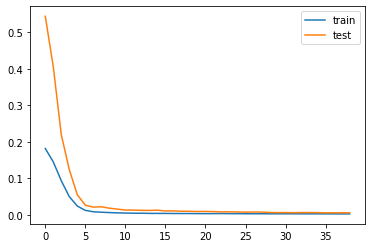

In [322]:
epochs = 120
batch_size = 21
validation = 0.0001
model_enc_dec = Sequential()
model_enc_dec.add(LSTM(60, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(60, activation='relu', return_sequences=True))
model_enc_dec.add(Dense(12,activation='relu'))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')
plot_model(model=model_enc_dec, show_shapes=True)
history = model_enc_dec.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_enc_dec.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test, yhat)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

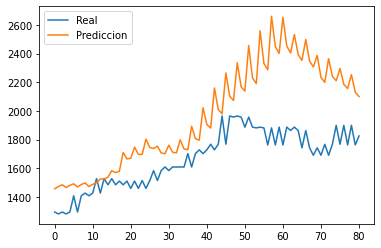

,real,prediccion
0,1295.4,1457.762939
1,1282.3,1473.273560
2,1295.6,1485.564331
3,1282.3,1466.247192
4,1295.6,1481.253784
5,1409.0,1492.210083
6,1295.6,1470.593140
7,1409.0,1487.533691
8,1427.6,1497.942505
9,1409.0,1472.740601


In [323]:
user=0
graph_predictions(y_test_inverse[:,user],yhat_inverse[:,user])
df_concat=pd.DataFrame({'real': y_test_inverse[:,user] , 'prediccion':yhat_inverse[:,user]})
df_concat.head(10)

# Nuevas predicciones

Predicciones nuevas de los Usuarios Segun las 3 ultima fechas saca la prediccion del nuevo mes de consumo

In [335]:
x_input = df_cpu_pivot.iloc[len(df_cpu_pivot)-LOOK_BACK:len(df_cpu_pivot),1:].values
x_input=scaler.transform(x_input)
x_input = x_input.reshape((1, LOOK_BACK, len(df_cpu_pivot.columns)-1))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [336]:
yhat = model_enc_dec.predict(x_input, verbose=0)
yhat = yhat.reshape(-1, yhat.shape[-1])
yhat = pd.DataFrame(scaler.inverse_transform(yhat))
yhat.insert(0, 'Date', pd.to_datetime(df_cpu_pivot['Date'].max(), format="%Y%m%d") + MonthBegin(1)+MonthEnd(1))

In [337]:
yhat.columns=df_2_plot.columns

In [338]:
df_2_plot = df_cpu_pivot.copy()
df_2_plot=df_2_plot.append(yhat,ignore_index=True)

In [352]:
users=df_cpu_pivot.columns
select_user=int(input('Ingrese el numero de usuario que desea predecir'))
user=users[select_user]


Ingrese el numero de usuario que desea predecir3


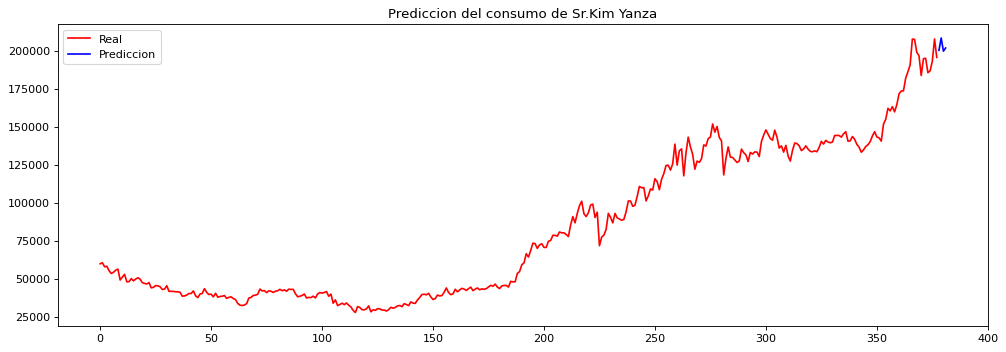

In [353]:
from matplotlib.pyplot import figure
figure(figsize=(15, 5), dpi=80)
plt.plot(np.where(df_2_plot['Date']<df_cpu_pivot.Date.max(),df_2_plot[user], None), color="red", label="Real")
plt.plot(np.where(df_2_plot['Date']>=df_cpu_pivot.Date.max(),df_2_plot[user], None), color="blue", label="Prediccion")
plt.title("Prediccion del consumo de Sr."+user)
plt.legend()